

**This notebook builds a robust complaint-handling pipeline:**
- TF-IDF + calibrated Logistic Regression fallback classifier
- SBERT semantic retrieval (FAISS if available; sklearn cosine fallback otherwise)
- Complaint → reply bank for high-quality template replies
- Stratified train / val / test splits, evaluation, and artifact saving

Run cells in order. If you install packages, you may need to restart the kernel and re-run imports.


**Install required packages**

In [1]:
import importlib, sys, subprocess

def ensure(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        importlib.import_module(import_name)
        return False
    except Exception:
        print(f'Installing {pkg}...')
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        return True

installed = False
installed |= ensure("sentence-transformers", "sentence_transformers")
installed |= ensure("faiss-cpu", "faiss")  # faiss may fail on some platforms but try
installed |= ensure("joblib")
installed |= ensure("matplotlib")
installed |= ensure("seaborn")

if installed:
    print("Packages installed. Please restart the kernel and re-run the notebook from the top (important).")
else:
    print("All packages already present.")

2025-11-22 18:47:11.245428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763837231.268301     102 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763837231.275118     102 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

All packages already present.


Imports

In [2]:
# Standard imports and checks
import os, random, sys
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics.pairwise import cosine_similarity

# sentence-transformers (SBERT)
from sentence_transformers import SentenceTransformer

# FAISS optional
USE_FAISS = True
try:
    import faiss
except Exception as e:
    print("faiss import failed — will fall back to sklearn cosine. Error:", e)
    USE_FAISS = False

print("Imports ready. FAISS available:", USE_FAISS)


Imports ready. FAISS available: True


**Paths, seeds, dataset detection**

In [3]:
# Deterministic behavior
SEED = 42
import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)

# Working directory
from pathlib import Path
import os

WORK_DIR = Path("/kaggle/working") if os.path.exists("/kaggle/working") else Path.cwd()
WORK_DIR.mkdir(parents=True, exist_ok=True)
print("Work dir:", WORK_DIR)

# UPDATED: Your dataset folder
DATASET_DIR = "/kaggle/input/complaint-dataset"

# Auto-find any CSV inside this folder
DATA_PATH = None
for file in os.listdir(DATASET_DIR):
    if file.lower().endswith(".csv"):
        DATA_PATH = os.path.join(DATASET_DIR, file)
        break

if DATA_PATH is None:
    raise FileNotFoundError("No CSV found inside /kaggle/input/complaint-dataset. Check file name.")

print("Using dataset:", DATA_PATH)


Work dir: /kaggle/working
Using dataset: /kaggle/input/complaint-dataset/complaints_unique_5000.csv


**Load and clean data**

In [4]:
df = pd.read_csv(DATA_PATH)
print("Raw rows:", len(df))
df = df.dropna(subset=["text","label"]).copy()
df["text"] = df["text"].astype(str).str.strip()
df = df[df["text"] != ""].reset_index(drop=True)
print("After cleaning rows:", len(df))
display(df.head())


Raw rows: 5000
After cleaning rows: 5000


,text,label
0,"Hi, The app crashes when I try to open the pro...",technical
1,"Hi, There is a wrong charge on my card ending ...",billing
2,"Hi, The courier left the package at a neighbor...",delivery
3,"Hello, My invoice has incorrect billing detail...",billing
4,"Hi, Images are not loading on the product page...",technical


**EDA (text lengths & class balance)**

label
technical    1000
billing      1000
delivery     1000
product      1000
account      1000
Name: count, dtype: int64

Text length stats:
 count    5000.000000
mean       11.869200
std         2.381097
min         6.000000
25%        10.000000
50%        12.000000
75%        13.000000
max        19.000000
Name: text_len, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


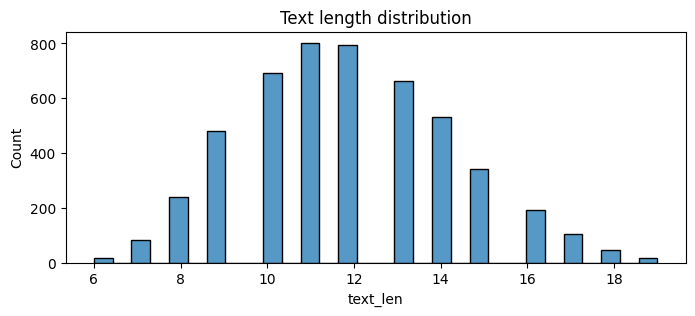

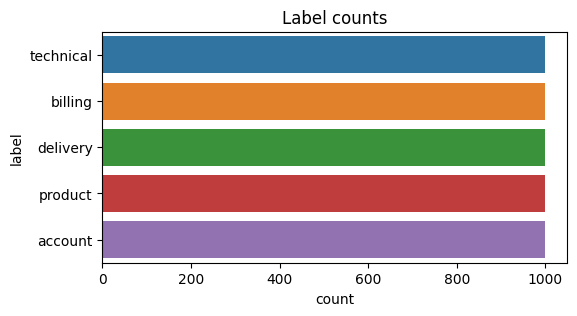

In [5]:
df["text_len"] = df["text"].str.split().apply(len)
print(df["label"].value_counts())
print("\nText length stats:\n", df["text_len"].describe())

plt.figure(figsize=(8,3))
sns.histplot(df["text_len"], bins=30)
plt.title("Text length distribution")
plt.show()

plt.figure(figsize=(6,3))
sns.countplot(y="label", data=df, order=df["label"].value_counts().index)
plt.title("Label counts")
plt.show()


**Train-Test-Split**

In [7]:
from sklearn.model_selection import train_test_split

X = df["text"].values
y = df["label"].values

# 15% test, 15% val, 70% train
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=SEED,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.17647,  # makes validation 15% of whole dataset
    random_state=SEED,
    stratify=y_trainval
)

print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))


Train size: 3500
Val size: 750
Test size: 750


**Train TF-IDF + LogisticRegression and calibrate**

In [9]:
# --------- Corrected Cell 8 ---------

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
clf = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=SEED)
pipeline = Pipeline([("tfidf", tfidf), ("clf", clf)])

print("Training TF-IDF + LogisticRegression ...")
pipeline.fit(X_train, y_train)
print("Training done.")

# IMPORTANT FIX: estimator= instead of base_estimator=
from sklearn.calibration import CalibratedClassifierCV

print("Calibrating probabilities on validation set (isotonic)...")
calibrated = CalibratedClassifierCV(estimator=pipeline, cv="prefit", method="isotonic")
calibrated.fit(X_val, y_val)
print("Calibration finished.")

# Save calibrated model
save_path = WORK_DIR / "pipeline_calibrated.joblib"
joblib.dump({"pipeline": calibrated}, save_path)
print("Saved calibrated pipeline to:", save_path)



Training TF-IDF + LogisticRegression ...
Training done.
Calibrating probabilities on validation set (isotonic)...
Calibration finished.
Saved calibrated pipeline to: /kaggle/working/pipeline_calibrated.joblib


**Evaluate fallback classifier**

Accuracy: 1.0
Macro F1: 1.0

Classification report:
               precision    recall  f1-score   support

     account       1.00      1.00      1.00       150
     billing       1.00      1.00      1.00       150
    delivery       1.00      1.00      1.00       150
     product       1.00      1.00      1.00       150
   technical       1.00      1.00      1.00       150

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



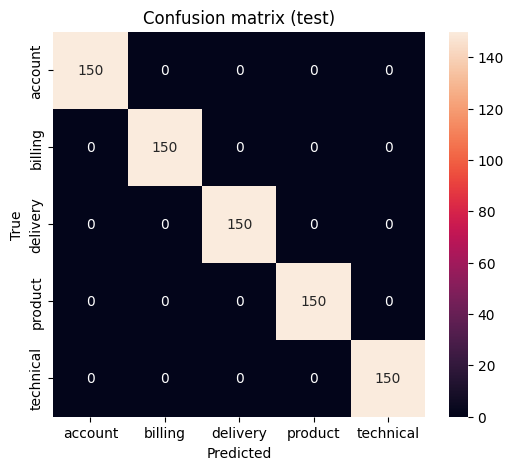

In [10]:
y_pred = calibrated.predict(X_test)
y_proba = calibrated.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:\n", classification_report(y_test, y_pred))

labels_sorted = np.unique(y)
cm = confusion_matrix(y_test, y_pred, labels=labels_sorted)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix (test)")
plt.show()


**Load SBERT and compute embeddings for full dataset**

In [11]:
sbert_model_name = "all-MiniLM-L6-v2"
print("Loading SBERT model:", sbert_model_name)
sbert = SentenceTransformer(sbert_model_name)

print("Computing SBERT embeddings for full dataset (this may take a bit)...")
full_texts = df["text"].tolist()
embeddings = sbert.encode(full_texts, show_progress_bar=True, convert_to_numpy=True)
print("Embeddings shape:", embeddings.shape)

# Save embeddings & meta
np.save(WORK_DIR / "embeddings_full.npy", embeddings)
joblib.dump({"sbert_model_name": sbert_model_name}, WORK_DIR / "sbert_meta.joblib")
print("Saved embeddings and sbert_meta.")


Loading SBERT model: all-MiniLM-L6-v2


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing SBERT embeddings for full dataset (this may take a bit)...


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Embeddings shape: (5000, 384)
Saved embeddings and sbert_meta.


**Build FAISS index (optional) or keep embeddings for cosine fallback**

In [12]:
if USE_FAISS:
    print("Building FAISS index (using normalized vectors for cosine via IP)...")
    emb_copy = embeddings.copy()
    faiss.normalize_L2(emb_copy)
    dim = emb_copy.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(emb_copy)
    faiss.write_index(index, str(WORK_DIR / "faiss_full.index"))
    np.save(WORK_DIR / "embeddings_full_norm.npy", emb_copy)
    print("FAISS index saved:", WORK_DIR / "faiss_full.index")
else:
    print("FAISS not available — embeddings saved (use sklearn cosine similarity).")


Building FAISS index (using normalized vectors for cosine via IP)...
FAISS index saved: /kaggle/working/faiss_full.index


**Create complaint→reply bank (sampled) and compute bank embeddings**

In [13]:
# Simple reply templates per label (you can edit)
reply_templates = {
    "billing": "Sorry about the billing issue. I will escalate this to the billing team and you will be updated shortly.",
    "delivery": "Apologies for the delivery problem. I will check the status and arrange a resolution.",
    "product": "Sorry for the trouble. Please share a photo and we will process a replacement or refund.",
    "account": "I understand the inconvenience. Please follow the reset link or contact support to regain access.",
    "technical": "Thanks for reporting this. Our technical team will investigate and get back to you soon."
}

bank = []
per_label = 100  # adjust if you want larger/smaller bank
for lbl in sorted(df["label"].unique()):
    samples = df[df["label"]==lbl].sample(n=min(per_label, len(df[df["label"]==lbl])), random_state=SEED)
    for _, r in samples.iterrows():
        bank.append({"text": r["text"], "label": lbl, "reply": reply_templates.get(lbl)})

print("Bank size:", len(bank))
bank_texts = [b["text"] for b in bank]
bank_embs = sbert.encode(bank_texts, show_progress_bar=True, convert_to_numpy=True)
np.save(WORK_DIR / "bank_embeddings.npy", bank_embs)
joblib.dump(bank, WORK_DIR / "complaint_bank.pkl")
print("Saved bank and bank embeddings")


Bank size: 500


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Saved bank and bank embeddings


**Build FAISS bank index**

In [14]:
if USE_FAISS:
    be = bank_embs.copy()
    faiss.normalize_L2(be)
    bank_idx = faiss.IndexFlatIP(be.shape[1])
    bank_idx.add(be)
    faiss.write_index(bank_idx, str(WORK_DIR / "faiss_bank.index"))
    np.save(WORK_DIR / "bank_embeddings_norm.npy", be)
    print("FAISS bank index saved:", WORK_DIR / "faiss_bank.index")
else:
    print("Faiss not available — using bank embeddings with sklearn cosine fallback.")


FAISS bank index saved: /kaggle/working/faiss_bank.index


**Inference helper: retrieval-first then fallback**

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# Load calibrated pipeline for inference if not in memory
calibrated_pipeline = joblib.load(WORK_DIR / "pipeline_calibrated.joblib")["pipeline"]

# Load bank and embeddings (in-memory)
bank = joblib.load(WORK_DIR / "complaint_bank.pkl")
bank_embs = None
bank_index = None
if USE_FAISS and (WORK_DIR / "faiss_bank.index").exists():
    bank_index = faiss.read_index(str(WORK_DIR / "faiss_bank.index"))
    bank_embs = np.load(WORK_DIR / "bank_embeddings_norm.npy")
else:
    if (WORK_DIR / "bank_embeddings.npy").exists():
        bank_embs = np.load(WORK_DIR / "bank_embeddings.npy")

def get_reply_for_text(text, sbert_model, bank, bank_embs=None, bank_index=None, tfidf_pipeline=None, sim_threshold=0.65, top_k=3):
    q = sbert_model.encode([text], convert_to_numpy=True)
    # FAISS path
    if USE_FAISS and bank_index is not None:
        faiss.normalize_L2(q)
        D, I = bank_index.search(q, top_k)
        best_sim = float(D[0][0])
        best_idx = int(I[0][0])
        if best_sim >= sim_threshold:
            matched = bank[best_idx]
            return {"method":"retrieval","similarity":best_sim,"label":matched["label"],"reply":matched["reply"],"matched_text":matched["text"]}
    # sklearn fallback
    if bank_embs is not None:
        sims = cosine_similarity(q, bank_embs)[0]
        best_idx = int(np.argmax(sims))
        best_sim = float(sims[best_idx])
        if best_sim >= sim_threshold:
            matched = bank[best_idx]
            return {"method":"retrieval","similarity":best_sim,"label":matched["label"],"reply":matched["reply"],"matched_text":matched["text"]}
    # fallback classifier
    pred = tfidf_pipeline.predict([text])[0]
    probs = tfidf_pipeline.predict_proba([text])[0]
    conf = float(np.max(probs))
    return {"method":"classifier","similarity":conf,"label":pred,"reply":reply_templates.get(pred),"matched_text":None}


**Demo a few examples**

In [17]:
examples = [
    "Hi, I was charged twice for my last order and need a refund please",
    "The courier left my parcel at wrong place and items are missing",
    "App crashes during checkout and payment fails every time",
    "I cannot reset my password and can't access my account"
]

for ex in examples:
    res = get_reply_for_text(ex, sbert, bank, bank_embs=bank_embs if bank_embs is not None else None, bank_index=bank_index, tfidf_pipeline=calibrated_pipeline)
    print("\nInput:", ex)
    print("Result:", res)



Input: Hi, I was charged twice for my last order and need a refund please
Result: {'method': 'retrieval', 'similarity': 0.7554190754890442, 'label': 'billing', 'reply': 'Sorry about the billing issue. I will escalate this to the billing team and you will be updated shortly.', 'matched_text': 'Hi, I need help with a missing refund for order'}

Input: The courier left my parcel at wrong place and items are missing
Result: {'method': 'retrieval', 'similarity': 0.7313281297683716, 'label': 'delivery', 'reply': 'Apologies for the delivery problem. I will check the status and arrange a resolution.', 'matched_text': 'Items were missing from my delivery my order'}

Input: App crashes during checkout and payment fails every time
Result: {'method': 'retrieval', 'similarity': 0.8112856149673462, 'label': 'technical', 'reply': 'Thanks for reporting this. Our technical team will investigate and get back to you soon.', 'matched_text': 'The app crashes when I try to open the checkout page ASAP. 47 2

**Save final artifacts for Streamlit**

In [18]:
ART_DIR = WORK_DIR / "complaint_artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

# Calibrated pipeline
joblib.dump({"pipeline": calibrated_pipeline}, ART_DIR / "pipeline.joblib")
# Bank and templates
joblib.dump({"bank": bank, "reply_templates": reply_templates}, ART_DIR / "bank_and_templates.joblib")
# Bank embeddings / FAISS index
if (WORK_DIR / "faiss_bank.index").exists():
    (WORK_DIR / "faiss_bank.index").replace(ART_DIR / "faiss_bank.index")
if (WORK_DIR / "bank_embeddings.npy").exists():
    (WORK_DIR / "bank_embeddings.npy").replace(ART_DIR / "bank_embeddings.npy")
if (WORK_DIR / "bank_embeddings_norm.npy").exists():
    (WORK_DIR / "bank_embeddings_norm.npy").replace(ART_DIR / "bank_embeddings_norm.npy")

joblib.dump({"sbert_model_name": sbert_model_name}, ART_DIR / "sbert_meta.joblib")
print("Artifacts saved to:", ART_DIR)


Artifacts saved to: /kaggle/working/complaint_artifacts
